In [1]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
from func.data_haystack import make_dataloader

In [2]:
# Configure test parameters
config = SimpleNamespace(
    n_input_values=10,  # Range of possible values (1-9)
    seq_len=64,         # Length of sequence
    qa_len=16,          # Length of QA pair (must be even)
    batch_size=4,      # Number of samples in batch
    num_samples=1_000,   # Total dataset size
    num_workers=0,      # Number of workers for dataloader
    cmap='rainbow',
)

In [3]:
# Create dataloader
dataloader = make_dataloader(config)

# Get one batch
batch = next(iter(dataloader))

In [4]:
def find_qa_pair(target, mask):
    """Extract the QA pair from the target using the mask position"""
    # Find where the mask starts (this is where answer starts)
    answer_start = torch.where(mask == 1)[0][0].item()
    answer_end = answer_start + config.qa_len//2
    question_start = answer_start - config.qa_len//2
    
    question = target[question_start:answer_start]
    answer = target[answer_start:answer_end]
    
    return question, answer

def plot_sequence(batch_idx, data):
    """Plot a single sequence with its components"""
    fig, axes = plt.subplots(7, 1, figsize=(15, 12))
    fig.suptitle(f'Sample {batch_idx}')
    
    # Get min and max values from input for consistent color mapping
    input_min = data['input'].min().item()
    input_max = data['input'].max().item()
    
    # Position IDs
    sns.heatmap(data['pos_id'][batch_idx].unsqueeze(0), 
                ax=axes[0], cmap='rainbow', cbar=False)
    axes[0].set_title('Position IDs')
    
    # Masked Input
    sns.heatmap(data['input'][batch_idx].unsqueeze(0), 
                ax=axes[1], cmap='rainbow', 
                vmin=input_min, vmax=input_max)
    axes[1].set_title('Masked Input (0 represents masked positions)')
    
    # Target
    sns.heatmap(data['target'][batch_idx].unsqueeze(0), 
                ax=axes[2], cmap='rainbow',
                vmin=input_min, vmax=input_max)
    axes[2].set_title('Target (Original sequence with QA pair)')
    
    # Mask
    sns.heatmap(data['mask'][batch_idx].unsqueeze(0), 
                ax=axes[3], cmap='bwr')
    axes[3].set_title('Mask (1 represents masked positions)')
    
    # Extract and plot QA pair
    question, answer = find_qa_pair(
        data['target'][batch_idx],
        data['mask'][batch_idx]
    )
    
    # Calculate scaling factor
    scale_factor = (config.seq_len) / config.qa_len 
    
    # Question
    sns.heatmap(question.unsqueeze(0), 
                ax=axes[4], cmap='rainbow',
                vmin=input_min, vmax=input_max,
                cbar=False)
    axes[4].set_title('Question Part')
    axes[4].set_aspect(scale_factor)


    # Answer
    sns.heatmap(answer.unsqueeze(0), 
                ax=axes[5], cmap='rainbow',
                vmin=input_min, vmax=input_max,
                cbar=False)
    axes[5].set_title('Answer Part (Masked in Input)')
    axes[5].set_aspect(scale_factor)


    # non-needle masked haystack
    sns.heatmap(data['needle_in_haystack'][batch_idx].unsqueeze(0), 
                ax=axes[6], cmap='rainbow',
                vmin=input_min, vmax=input_max,)
    axes[6].set_title('only visualize needle')

    plt.tight_layout()
    return fig

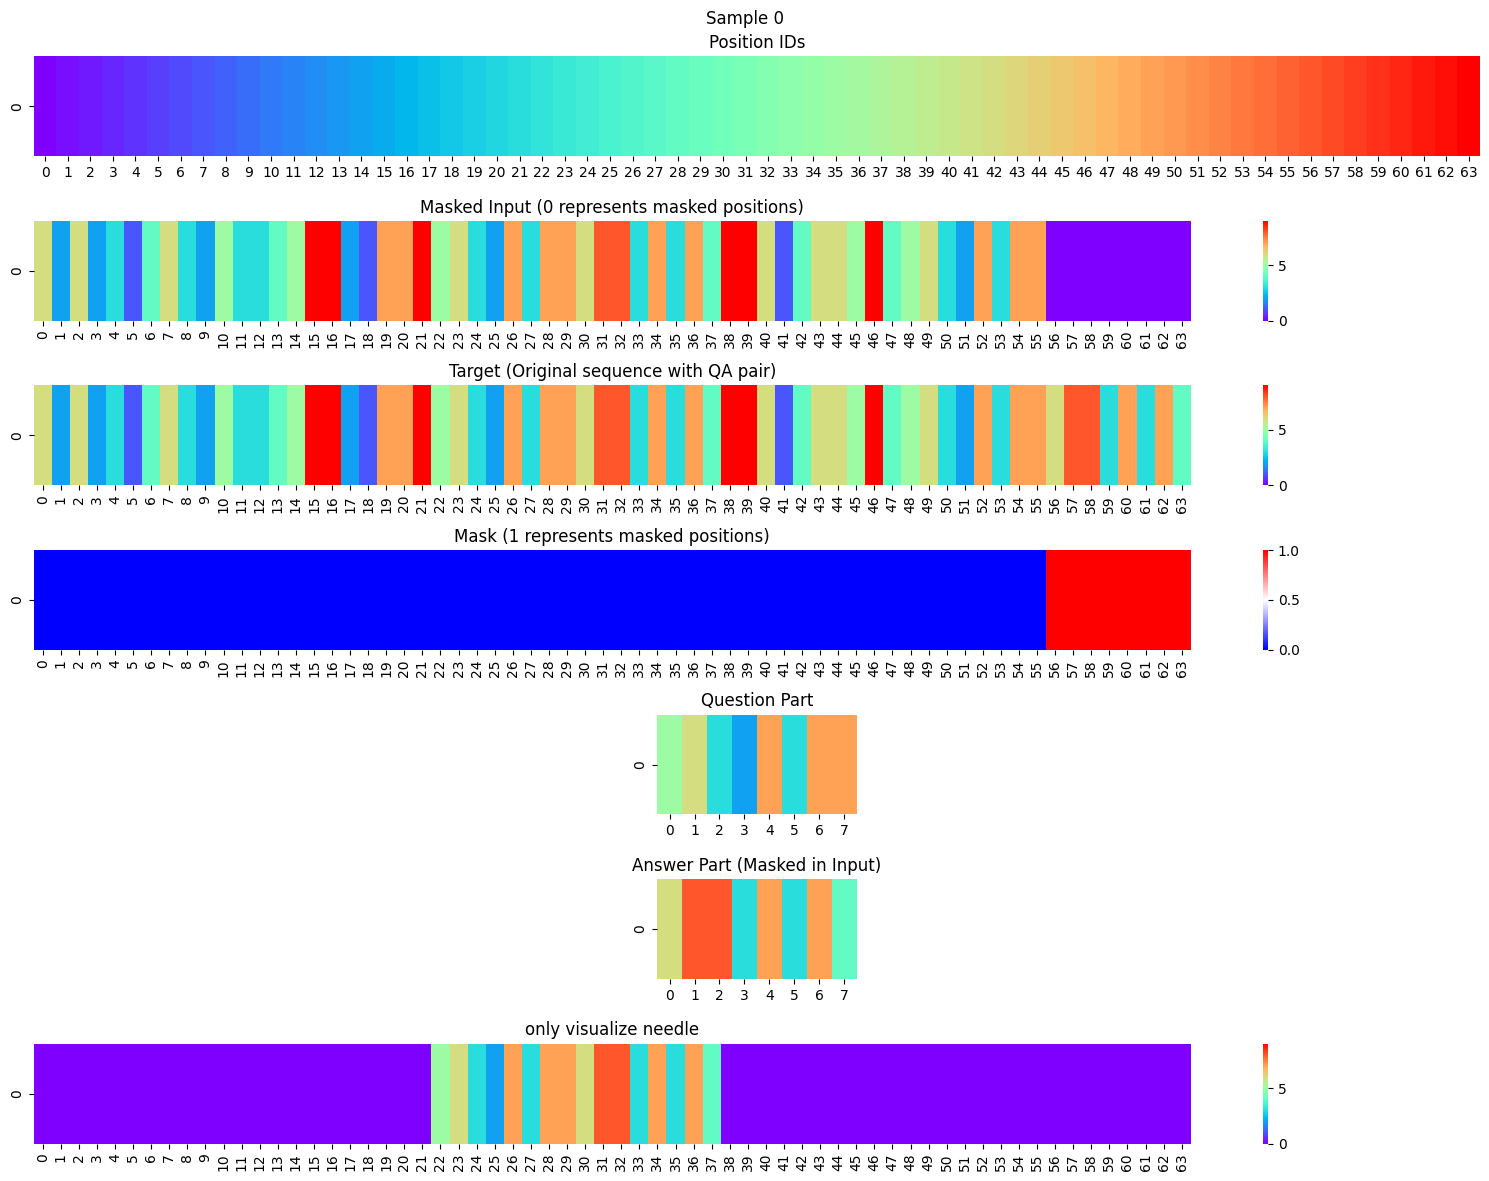

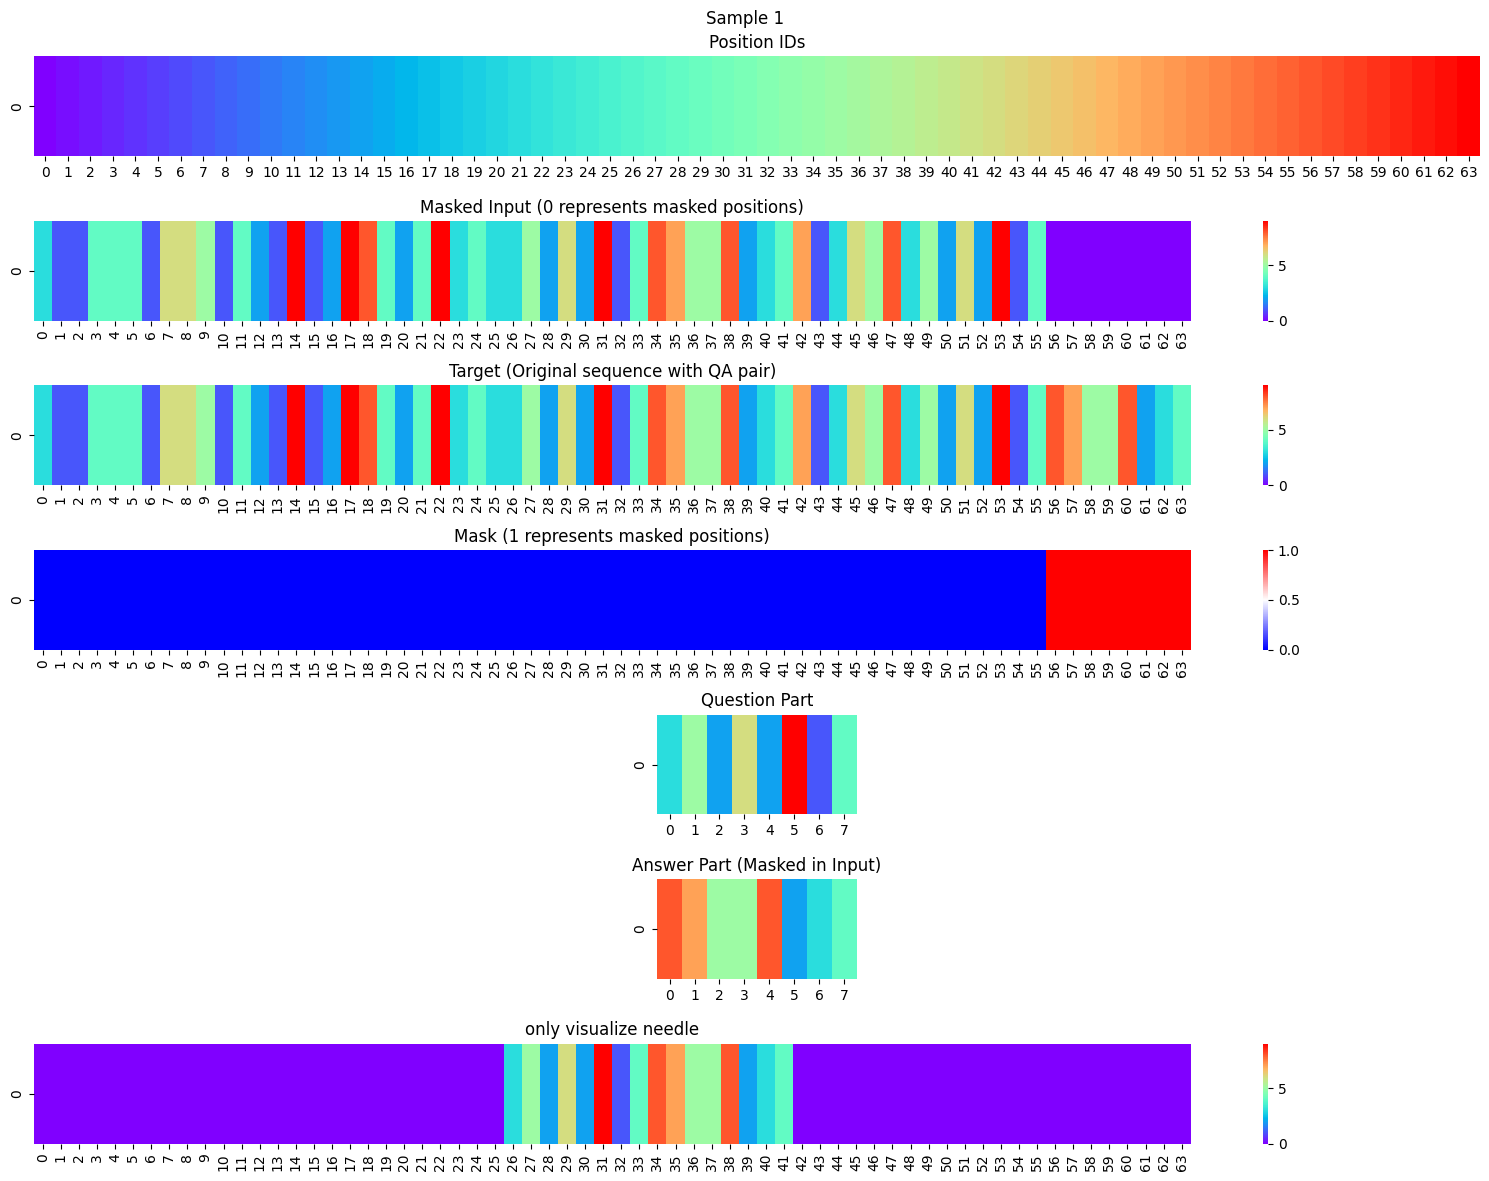

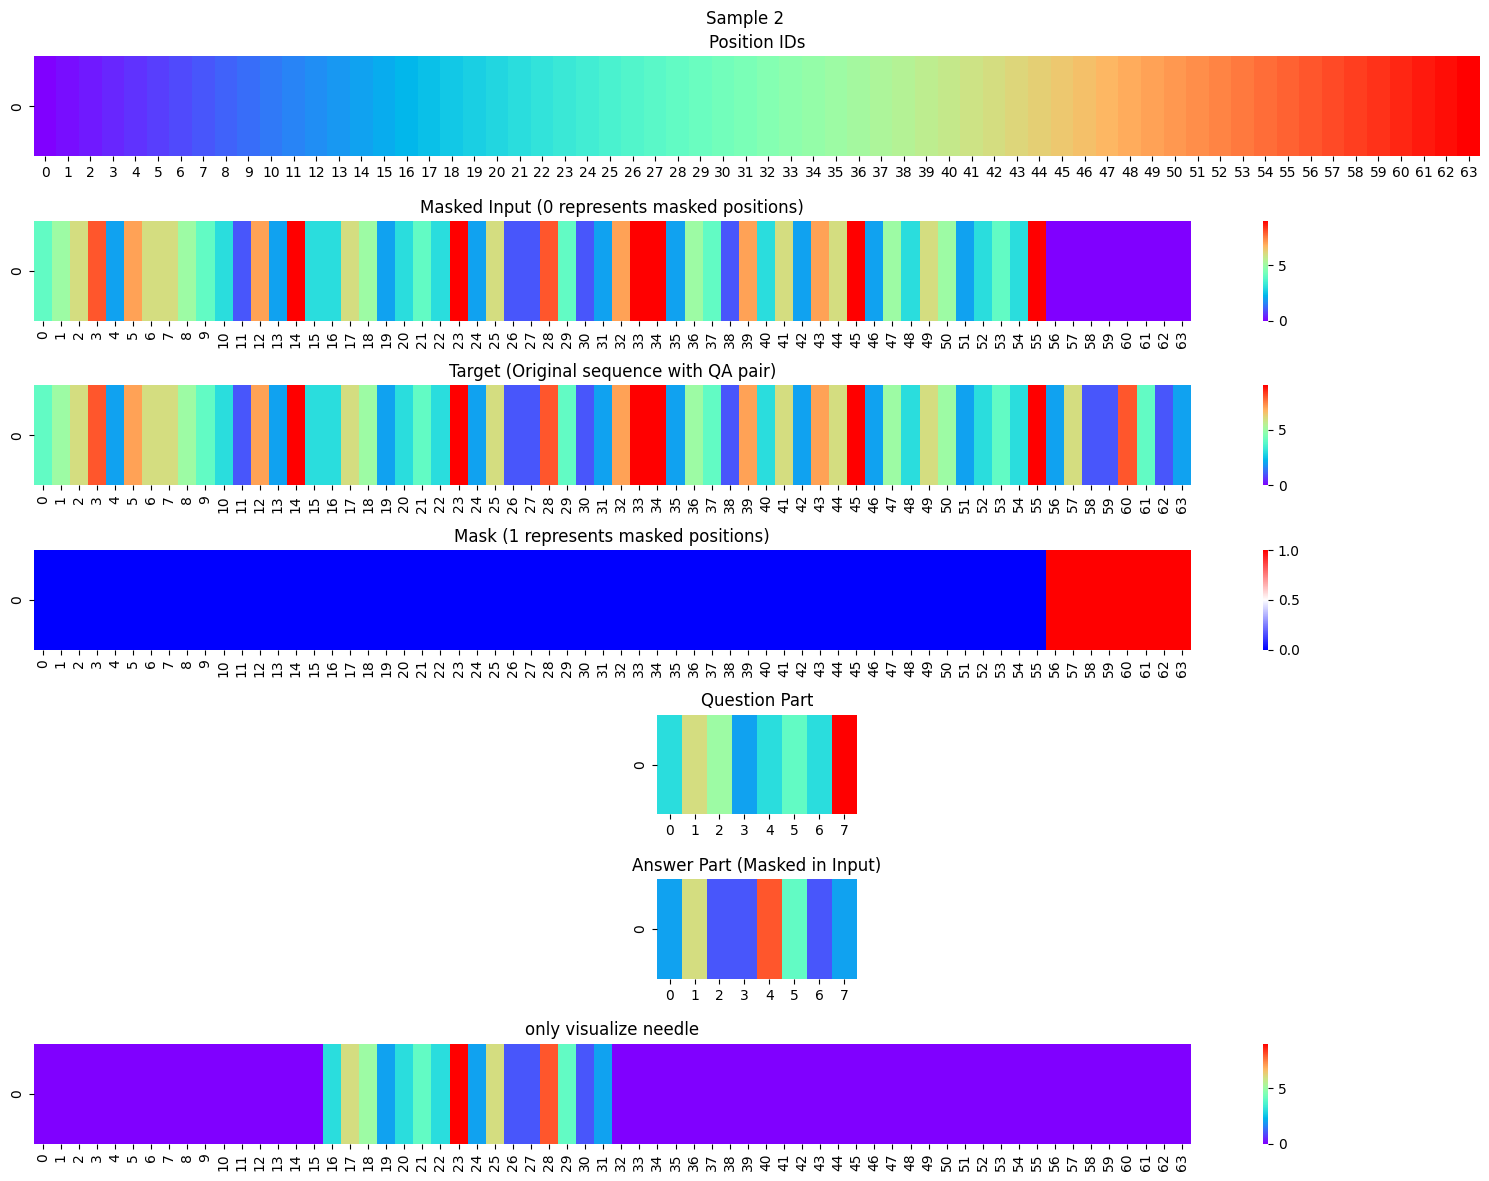

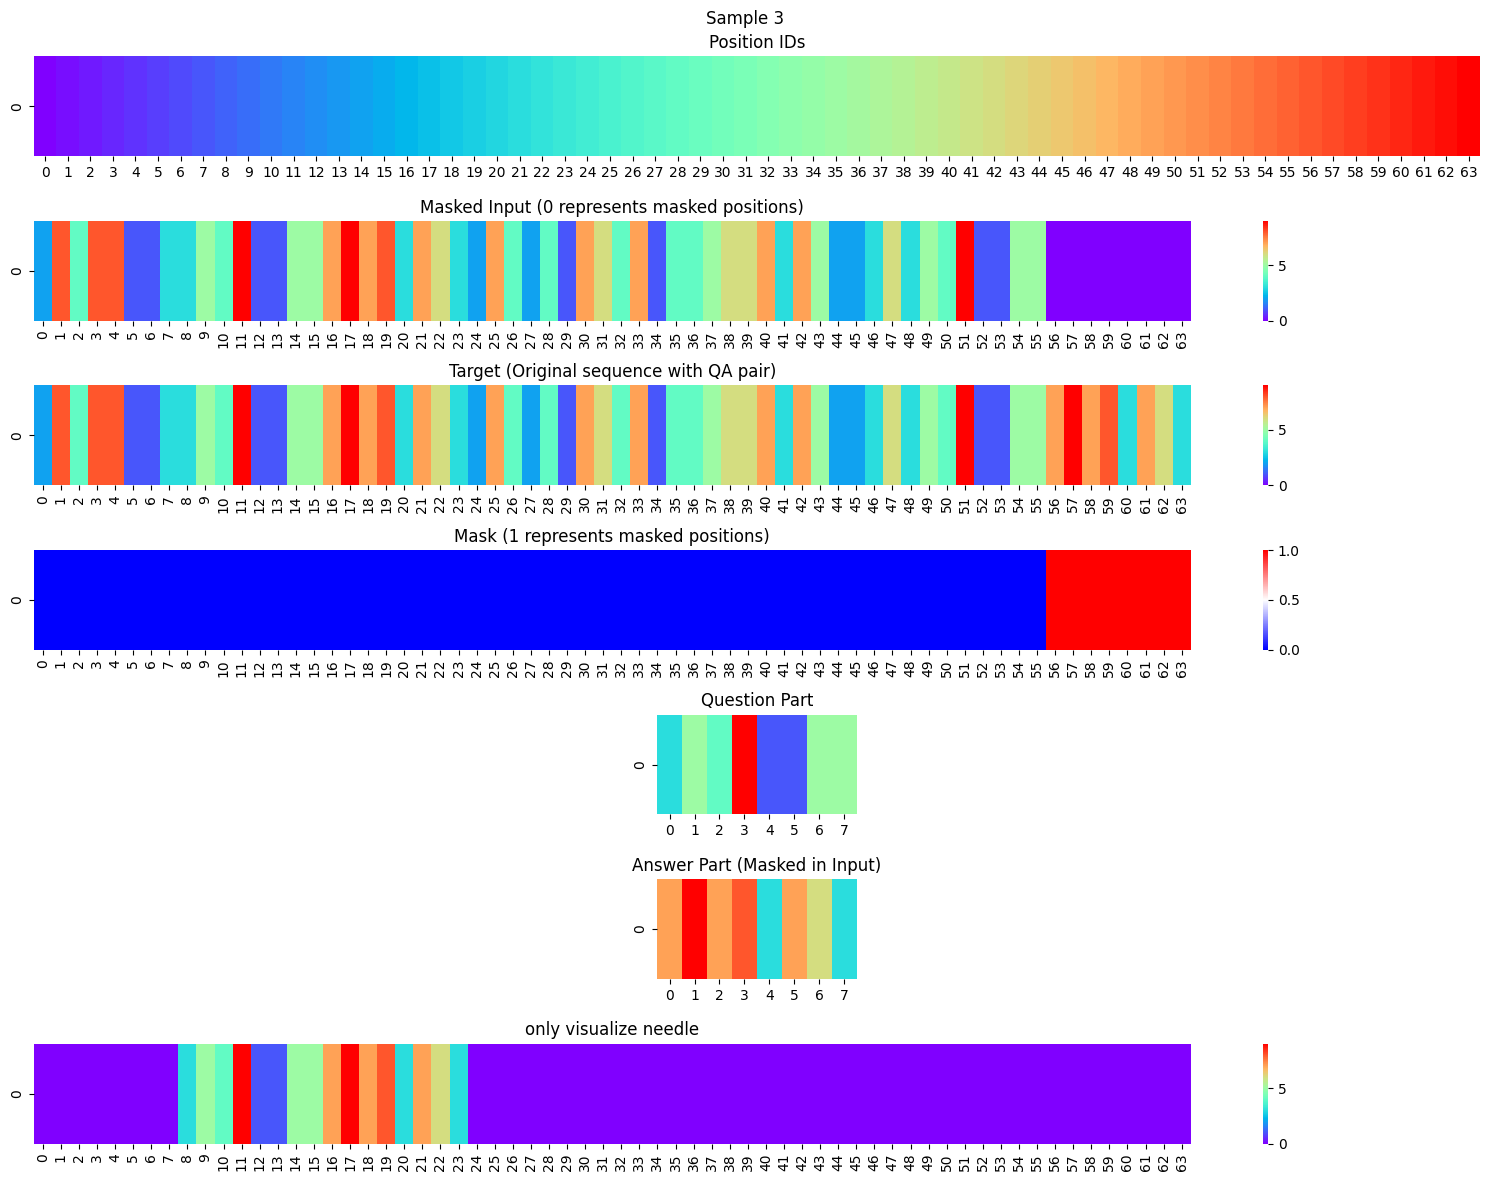

In [5]:
# Plot each sample in the batch
for i in range(config.batch_size):
    fig = plot_sequence(i, batch)
    plt.show()

In [6]:
# Verification checks
def verify_data(batch):
    print("Verification Results:")
    
    # Check shapes
    print(f"\nShapes:")
    for key, value in batch.items():
        print(f"{key}: {value.shape}")
    
    # Verify mask positions match zeros in input
    mask_matches = torch.all((batch['mask'] == 1) == (batch['input'] == 0))
    print(f"\nMask positions match zeros in input: {mask_matches}")
    
    # Verify non-masked positions match between input and target
    non_masked_match = torch.all(
        batch['input'] * (1 - batch['mask']) == 
        batch['target'] * (1 - batch['mask'])
    )
    print(f"Non-masked positions match between input and target: {non_masked_match}")
    
    # Check if values are within expected range
    input_range = (batch['input'].min(), batch['input'].max())
    target_range = (batch['target'].min(), batch['target'].max())
    print(f"\nValue ranges:")
    print(f"Input values range: {input_range}")
    print(f"Target values range: {target_range}")
    
    # Verify QA pairs
    print("\nQA Pair Analysis:")
    for i in range(len(batch['target'])):
        question, answer = find_qa_pair(batch['target'][i], batch['mask'][i])
        print(f"\nSample {i}:")
        print(f"Question: {question.tolist()}")
        print(f"Answer: {answer.tolist()}")

verify_data(batch)

Verification Results:

Shapes:
pos_id: torch.Size([4, 64])
input: torch.Size([4, 64])
target: torch.Size([4, 64])
mask: torch.Size([4, 64])
needle_in_haystack: torch.Size([4, 64])

Mask positions match zeros in input: True
Non-masked positions match between input and target: True

Value ranges:
Input values range: (tensor(0), tensor(9))
Target values range: (tensor(1), tensor(9))

QA Pair Analysis:

Sample 0:
Question: [5, 6, 3, 2, 7, 3, 7, 7]
Answer: [6, 8, 8, 3, 7, 3, 7, 4]

Sample 1:
Question: [3, 5, 2, 6, 2, 9, 1, 4]
Answer: [8, 7, 5, 5, 8, 2, 3, 4]

Sample 2:
Question: [3, 6, 5, 2, 3, 4, 3, 9]
Answer: [2, 6, 1, 1, 8, 4, 1, 2]

Sample 3:
Question: [3, 5, 4, 9, 1, 1, 5, 5]
Answer: [7, 9, 7, 8, 3, 7, 6, 3]
